In [1]:
# Imports
import requests
import json

In [5]:
# Billing Status
from Helper import StakingRewardsAPIClient

client = StakingRewardsAPIClient()
status = client.get_billing_status()
print(status)

{'plan_name': 'startup yearly v0', 'available_credits': 1487007, 'monthly_quota': 1500000, 'subscribed_at': '2025-11-24T07:32:41Z', 'requests_allowed': True, 'billing_date': '2025-12-24T07:32:41Z'}


In [5]:
# Asset Queries
eth = client.get_assets(symbols=["ETH"], limit=1)
print(eth)

DEBUG - Query: 
        {
          assets(where: {symbols: ["ETH"]}, limit: 3) {
            id
            name
            slug
            description
            symbol
          }
        }
        
{'data': {'assets': [{'id': '5d27aa0de03dd80007d1eb49', 'name': 'Ethereum', 'slug': 'ethereum-2-0', 'description': "the world's largest and most decentralized Layer1 blockchain. The network is used for building dApps, holding assets, transacting and communicating without being controlled by a central authority. The Ethereum vision is to build a digital future on a global scale, that is powerful enough to help all of humanity", 'symbol': 'ETH'}]}}


In [4]:
result = client.get_asset_metrics(
      slug="polkadot",
      metric_keys=["reward_rate", "provider"],
      created_before="2023-06-28",
      metrics_limit=10
  )
print(result)

{'data': {'assets': [{'id': '5d27aa0ee03dd80007d1eb6d', 'slug': 'polkadot', 'logoUrl': 'https://coin-images.coingecko.com/coins/images/12171/large/polkadot.png?1696512008', 'metrics': [{'defaultValue': 14.835948403683611, 'createdAt': '2023-06-27T22:01:16.026146Z'}, {'defaultValue': 14.835916173737743, 'createdAt': '2023-06-27T20:01:07.394307Z'}, {'defaultValue': 14.835696505476331, 'createdAt': '2023-06-27T18:11:07.667837Z'}, {'defaultValue': 14.835516951370295, 'createdAt': '2023-06-27T16:01:13.578876Z'}, {'defaultValue': 14.852641094515928, 'createdAt': '2023-06-27T14:01:58.737205Z'}, {'defaultValue': 14.852593442400858, 'createdAt': '2023-06-27T12:10:17.547877Z'}, {'defaultValue': 14.852589686723764, 'createdAt': '2023-06-27T10:01:22.273959Z'}, {'defaultValue': 14.85250720223731, 'createdAt': '2023-06-27T08:01:23.624704Z'}, {'defaultValue': 14.8524890814507, 'createdAt': '2023-06-27T06:01:55.861665Z'}, {'defaultValue': 14.852486411180484, 'createdAt': '2023-06-27T04:01:27.988426Z'}

In [4]:
providers = client.get_providers(asset_slug="cosmos")
print(providers)

{'data': {'providers': [{'slug': 'p2p-validator', 'rewardOptions': [{'metrics': [{'defaultValue': 19.06351149935919}]}]}, {'slug': 'figment-networks', 'rewardOptions': [{'metrics': [{'defaultValue': 18.818428911935055}]}]}, {'slug': 'kiln', 'rewardOptions': [{'metrics': [{'defaultValue': 19.01100151971126}]}]}, {'slug': 'allnodes', 'rewardOptions': [{'metrics': [{'defaultValue': 18.649477739423034}]}]}, {'slug': 'stake-fish', 'rewardOptions': [{'metrics': [{'defaultValue': 19.683184510055003}]}]}, {'slug': 'hashquark', 'rewardOptions': [{'metrics': [{'defaultValue': 19.65423787482338}]}]}, {'slug': 'chorus-one', 'rewardOptions': [{'metrics': [{'defaultValue': 19.151953968578734}]}]}, {'slug': 'nansen', 'rewardOptions': [{'metrics': [{'defaultValue': 19.65281496138043}]}]}, {'slug': 'stakin', 'rewardOptions': [{'metrics': [{'defaultValue': 19.67435992498762}]}]}, {'slug': 'stakely', 'rewardOptions': [{'metrics': [{'defaultValue': 19.683700132547347}]}]}]}}


In [4]:
# Total market cap
client.get_metrics(limit=1)

{'data': {'metrics': [{'defaultValue': 3183384258474.3066,
    'changeAbsolutes': '{"1y": -124284384191.89453, "7d": 13913124235.17871, "24h": 99242363989.19092, "30d": -758711371721.6655, "90d": -791154185015.4048}',
    'changePercentages': '{"1y": -3.7574617538385904, "7d": 0.43897305404924386, "24h": 3.217827434160872, "30d": -19.246396914119202, "90d": -19.90556126866289}',
    'createdAt': '2025-11-26T22:03:08.928548Z'}]}}

In [4]:
# Find the top providers for a coin
validators = client.get_validators(symbol="ETH", limit=4)
print(validators)

{'data': {'assets': [{'id': '5d27aa0de03dd80007d1eb49', 'name': 'Ethereum', 'slug': 'ethereum-2-0', 'description': "the world's largest and most decentralized Layer1 blockchain. The network is used for building dApps, holding assets, transacting and communicating without being controlled by a central authority. The Ethereum vision is to build a digital future on a global scale, that is powerful enough to help all of humanity", 'symbol': 'ETH', 'metrics': [{'metricKey': 'active_validators', 'label': 'Active Validators', 'defaultValue': 923301}]}]}}


In [3]:
# Find the staked tokens for a asset slug
result = client.get_staked_tokens(asset_slug="cosmos", limit=10)
print(result)

{'data': {'rewardOptions': [{'providers': None, 'validators': [{'address': None, 'status': {'label': 'unknown'}, 'metrics': None}]}, {'providers': [{'slug': 'chorus-one'}], 'validators': [{'address': 'cosmosvaloper15urq2dtp9qce4fyc85m6upwm9xul3049e02707', 'status': {'label': 'active'}, 'metrics': [{'metricKey': 'staked_tokens', 'defaultValue': 5278968.642348851}]}]}, {'providers': [{'slug': 'nansen'}], 'validators': [{'address': 'cosmosvaloper1jlr62guqwrwkdt4m3y00zh2rrsamhjf9num5xr', 'status': {'label': 'active'}, 'metrics': [{'metricKey': 'staked_tokens', 'defaultValue': 4086149.456492351}]}]}, {'providers': [{'slug': 'p2p-validator'}], 'validators': [{'address': 'cosmosvaloper132juzk0gdmwuxvx4phug7m3ymyatxlh9734g4w', 'status': {'label': 'active'}, 'metrics': [{'metricKey': 'staked_tokens', 'defaultValue': 5342077.522632887}]}, {'address': 'wl_node_cosmos_p2p-validator_1', 'status': {'label': 'active'}, 'metrics': [{'metricKey': 'staked_tokens', 'defaultValue': 249258}]}]}, {'provider

In [72]:
### Query 1, get all assets

query = """
{
  assets(limit: 500) {
    slug
    id
  }
}
"""

result = client.execute_raw_query(query)
assets = result['data']['assets']

print(f'Number of assets: {len(assets)}')
print('\n'.join(item['slug'] for item in assets))

Number of assets: 500
cardano
waves
stellar
eos
tron
cosmos
ethereum-2-0
ontology
algorand
polkadot
chainlink
gnosis
livepeer
irisnet
dai
energi
secret-network
orbs
terra
tezos
havven
harmony
solana
near-protocol
kava
crypto-com-coin
skale
avalanche
fantom
elrond
kusama
coti
makerdao
telos
chromia
usd-coin
bitcoin
tether
aave
maker
trueusd
decentraland
nusd
kyber-network
matic-network
band-protocol
e-money
yearn-finance
true-usd
curve-dao-token
paxos-standard
litecoin
ripple
gemini-dollar
persistence
the-graph
akash
stafi-protocol
mantra-dao
pax-gold
nimiq
uniswap
sushi
pancakeswap
binance-smart-chain
flow
injective-protocol
certik
fuse-network-token
filecoin
orchid-protocol
balancer
wrapped-bitcoin
sentinel
stasis-eurs
regen
mina
hydra
euro-coin
dydx
axie-infinity
akropolis
api3
sifchain
dogecoin
rocket-pool
paraswap
presearch
osmosis
staked-near
evmos
radix
comdex
phala-network
apecoin
aavegotchi
asset-mantle
terra-luna-2
frax
ethereum-name-service
cheqd
cudos
agoric
axelar
desmos
ju

In [82]:
## Get market cap for an asset
query = """
{
   assets(where: {slugs: ["cardano"], isActive: Any}, limit: 1) {
        metrics(limit: 10) {
            metricKey
            defaultValue
        }
    }
}
"""
result = client.execute_raw_query(query)
print(json.dumps(result, indent=4))

{
    "data": {
        "assets": [
            {
                "metrics": [
                    {
                        "metricKey": "net_staking_flow",
                        "defaultValue": 0
                    },
                    {
                        "metricKey": "benchmark_commission",
                        "defaultValue": 27.20370481652398
                    },
                    {
                        "metricKey": "annualized_rewards_usd",
                        "defaultValue": 206332312.6834773
                    },
                    {
                        "metricKey": "staking_roi_365d",
                        "defaultValue": 2.60051560993422
                    },
                    {
                        "metricKey": "block_time_target",
                        "defaultValue": 20
                    },
                    {
                        "metricKey": "staked_tokens_trend_24h",
                        "defaultValue": -1
             

In [5]:
query = """
{
  providers(limit: 10) {
    name
    logoUrl
    country
    rewardOptions(limit: 5) {
      id
      type {
        key
        label
      }
      metrics(limit: 10) {
        metricKey
        defaultValue
      }
    }
  }
}
"""
result = client.execute_raw_query(query)
print(result)

{'data': {'providers': [{'name': 'Staked', 'logoUrl': 'https://storage.googleapis.com/stakingrewards-static/images/providers/production/eigenlayer/0x6573629204b65faac121c1b556b91a694d0e23c8.png', 'country': 'us', 'rewardOptions': [{'id': '5d34930fe03dd8000780b7a3', 'type': {'key': 'pos', 'label': 'pos'}, 'metrics': [{'metricKey': '30d_apr', 'defaultValue': 0.08998984800567686}, {'metricKey': 'activation_time', 'defaultValue': 1532036007.0}, {'metricKey': 'assets_under_management', 'defaultValue': 20790326.193907466}, {'metricKey': 'available_capacity', 'defaultValue': 3661230.503659999}, {'metricKey': 'available_delegation_capacity', 'defaultValue': 25086187.982741}, {'metricKey': 'available_staking_capacity', 'defaultValue': 7797101.096441001}, {'metricKey': 'baking_power', 'defaultValue': 35489982413494.0}, {'metricKey': 'block_fees', 'defaultValue': 22715688.0}, {'metricKey': 'block_rewards', 'defaultValue': 4025555365.0}, {'metricKey': 'capacity', 'defaultValue': 13579097.84568}]},

In [13]:
query = """
{
  metrics(
    where: {
      rewardOption: null
      validator: null
      metricKeys: ["marketcap"]
    }
    limit: 1
  ) {
    defaultValue
    changeAbsolutes
    changePercentages
    createdAt
    asset
    provider
  }
}
"""
result = client.execute_raw_query(query)
print(result)

HTTPError: 400 Client Error: Bad Request for url: https://api.stakingrewards.com/public/query

In [17]:
## Get staked tokens marketcap

query = """
{
  assets(where: { slugs: ["cardano"] }, limit: 1) {
    slug
    id
    metrics(where: { metricKeys: ["staked_tokens"] }, limit: 1) {
      metricKey
      defaultValue
      changeAbsolutes
      changePercentages
    }
  }
}
"""
result = client.execute_raw_query(query)
print(result)

{'data': {'assets': [{'slug': 'cardano', 'id': '5d27aa08e03dd80007d1ea6e', 'metrics': [{'metricKey': 'staked_tokens', 'defaultValue': 21404584013.280006, 'changeAbsolutes': '{"1y": -508059700.4425316, "7d": -13162949.566673279, "24h": 72252725.34853745, "30d": -476870547.12327576, "90d": -481099996.4971657}', 'changePercentages': '{"1y": -2.318568708915598, "7d": -0.06145814305074675, "24h": 0.33870055913398284, "30d": -2.179336596691435, "90d": -2.1982406228758484}'}]}]}}


In [33]:
query = """
{
  rewardOptions(
    where: {
      inputAsset: { slugs: ["cardano"] }
      typeKeys: ["pos"]
    }
    limit: 10
    offset: 0
  ) {
    providers(limit: 2) {
      slug
    }
    validators(limit: 100) {
      address
      status {
        label
      }
      metrics(where: { metricKeys: ["staked_tokens"] }, limit: 1) {
        metricKey
        defaultValue
      }
    }
  }
}
"""
result = client.execute_raw_query(query)
rewardOptions = result['data']['rewardOptions']
sum = 0.0
for rewardOption in rewardOptions:
    providers = rewardOption['providers']
    for provider in providers:
        print(provider['slug'])
    validators = rewardOption['validators']
    for validator in validators:
        metrics = validator['metrics']
        for metric in metrics:
            if metric['metricKey'] == 'staked_tokens':
                print(metric['defaultValue'])
                sum += metric['defaultValue']

print(sum)

cardanoamsterdam
3810102.152475
clrpool
4423103.941152
1-percent-pool-v2
917197.994816
10526694.43946
10092043.237211
8357436.039044
243405.922763
370298.756069
2532711.645362
grow-team
13612206.585791
stakenuts
5717669.946991
zion-stake-pool
2229474.909243
adafr
71338919.847084
mango-farm
1366554.680694
banderini
18943545.922984
queen-ada
55370140.703104
209851506.724243


In [16]:
# More Asset Properties
query = """
{
  assets(where: { symbols: ["ETH"] }, limit: 1) {
    slug
    id
    logoUrl
    underlyingAssets
  }
}
"""

result = client.execute_raw_query(query)
print(result)


HTTPError: 400 Client Error: Bad Request for url: https://api.stakingrewards.com/public/query

In [88]:
## Reward Options
query = """
{
    rewardOptions(
        where: { providers: { slugs: ["allnodes"] } }
        limit: 10
        order: { metricKey_desc: "staked_tokens" }
      ) {
        inputAssets(limit: 1) {
          slug
        }
        metrics(where: { metricKeys: ["staked_tokens"] }, limit: 1) {
          defaultValue
        }
        validators(limit: 10) {
          address
          metrics(
            where: {
              metricKeys: [
                "commission"
                "staking_wallets"
                "self_staked_tokens"
                "staked_tokens"
                "reward_rate"
                "staking_share"
                "net_staking_flow_7d"
              ]
            }
            limit: 7
          ) {
            label
            metricKey
            defaultValue
          }
        }
    }
}

"""
result = client.execute_raw_query(query)
print(json.dumps(result, indent=4))

{
    "data": {
        "rewardOptions": [
            {
                "inputAssets": [
                    {
                        "slug": "sifchain"
                    }
                ],
                "metrics": [
                    {
                        "defaultValue": 1451724725.5518897
                    }
                ],
                "validators": [
                    {
                        "address": "sifvaloper1ddlw0cz4v0grzek88z0vm34ktcfsac8du78yhg",
                        "metrics": [
                            {
                                "label": "Commission",
                                "metricKey": "commission",
                                "defaultValue": 10
                            },
                            {
                                "label": "Net Staking Flow 7d",
                                "metricKey": "net_staking_flow_7d",
                                "defaultValue": -3978.159562291
                      

In [111]:
## Reward Options - for an asset get the providers
query = """
{
    rewardOptions(
        where: { inputAsset: { slugs: ["ethereum-2-0"] } }
        limit: 20
      ) {
        providers(where: { isActive: True } limit: 20) {
            id
            slug
            type {
               key
               label
            }
            name
            country
        }
    }
}
"""
result = client.execute_raw_query(query)
print(json.dumps(result, indent=4))

{
    "data": {
        "rewardOptions": [
            {
                "providers": [
                    {
                        "id": "5eca1f4f159b3a0007b4a132",
                        "slug": "blockdaemon",
                        "type": {
                            "key": "pos",
                            "label": "pos"
                        },
                        "name": "Blockdaemon",
                        "country": "US"
                    }
                ]
            },
            {
                "providers": [
                    {
                        "id": "5d349314e03dd8000780b818",
                        "slug": "infstones",
                        "type": {
                            "key": "pos",
                            "label": "pos"
                        },
                        "name": "InfStones",
                        "country": "US"
                    }
                ]
            },
            {
                "providers"

In [124]:
query = """
{
  rewardOptions(
    where: {
      providers: { slugs: ["kiln"] }
      inputAsset: { slugs: ["solana"] }
    }
    limit: 20
    order: { metricKey_desc: "staked_tokens" }
  ) {
    id
    inputAssets(limit: 1) { slug }
    metrics(where: { metricKeys: ["staked_tokens"] }, limit: 2) { defaultValue }
    validators(limit: 10) {
      id
      address
    }
  }
}

"""
result = client.execute_raw_query(query)
print(json.dumps(result, indent=4))
response = result
total_staked_tokens = sum(
    ro["metrics"][0]["defaultValue"]
    for ro in response.get("data", {}).get("rewardOptions", [])
    if ro.get("metrics") and ro["metrics"][0].get("defaultValue") is not None
)

print(f"Total staked tokens: {total_staked_tokens}")

{
    "data": {
        "rewardOptions": [
            {
                "id": "2HvPGpm5slQCvekiT10J9Q==",
                "inputAssets": [
                    {
                        "slug": "solana"
                    }
                ],
                "metrics": [
                    {
                        "defaultValue": 9938572.238318413
                    }
                ],
                "validators": [
                    {
                        "id": "61671f01540b1d00076dd10d",
                        "address": "DdCNGDpP7qMgoAy6paFzhhak2EeyCZcgjH7ak5u5v28m"
                    },
                    {
                        "id": "668703ef0cac9717026caf27",
                        "address": "HCvnhbT3Sn5RsueDisWzzn5FkW8tAqoQK1dr7cvAVzin"
                    },
                    {
                        "id": "67c875373e68b89bfbdb76f5",
                        "address": "wl_node_solana_Kiln-validator_1"
                    },
                    {
          

In [40]:
## Global Market Cap
query = """
{
  assets(where: {symbols: ["ETH"]}, limit: 1) {
    id
    name
    slug
    symbol
    metrics(where: {metricKeys: ["price", "staking_marketcap"] }, limit: 10) {
      metricKey
      unit
      defaultValue
      changePercentages
    }
  }
}
"""
result = client.execute_raw_query(query)
print(json.dumps(result, indent=4))


{
    "data": {
        "assets": [
            {
                "id": "5d27aa0de03dd80007d1eb49",
                "name": "Ethereum",
                "slug": "ethereum-2-0",
                "symbol": "ETH",
                "metrics": [
                    {
                        "metricKey": "price",
                        "unit": "USD",
                        "defaultValue": 3089.26,
                        "changePercentages": "{\"1y\": -21.139840557105614, \"7d\": 1.7797604143329833, \"24h\": -5.025040658404832, \"30d\": -12.535355222663583, \"90d\": -33.87232803757122}"
                    },
                    {
                        "metricKey": "staking_marketcap",
                        "unit": "USD",
                        "defaultValue": 110263359075.80104,
                        "changePercentages": "{\"1y\": -16.636824825596698, \"7d\": 1.764214626514329, \"24h\": -5.025113547392528, \"30d\": -12.723263230582102, \"90d\": -34.02657060912577}"
                   

In [46]:
# Global Metrics
query = """
{
  metrics(
    where: {
      asset: null
      provider: null
      rewardOption: null
      validator: null
      metricKeys: ["staking_marketcap", "pos_assets_marketcap", "staking_wallets", "total_vsp_aum", "pow_assets_marketcap", "total_vsps"]
    }
    limit: 10
  ) {
    id
    defaultValue
    changeAbsolutes
    changePercentages
    createdAt
    metricKey
  }
}
"""
result = client.execute_raw_query(query)
print(json.dumps(result, indent=4))

{
    "data": {
        "metrics": [
            {
                "id": "693d0f19d757e0be21cbe206",
                "defaultValue": 12075147.0,
                "changeAbsolutes": "{\"1y\": 644592, \"7d\": 195178, \"24h\": 181277, \"30d\": -125015, \"90d\": -206654}",
                "changePercentages": "{\"1y\": 5.639201246133718, \"7d\": 1.6429167449847724, \"24h\": 1.524121249013147, \"30d\": -1.024699508088499, \"90d\": -1.6826033901705457}",
                "createdAt": "2025-12-13T07:00:41.872042Z",
                "metricKey": "staking_wallets"
            },
            {
                "id": "693d0f19d757e0be21cbe202",
                "defaultValue": 2467075849793.0967,
                "changeAbsolutes": "{\"1y\": -397671492424.42725, \"7d\": 16798048725.992676, \"24h\": -71581536418.47607, \"30d\": -367999761570.0542, \"90d\": -852298728399.6538}",
                "changePercentages": "{\"1y\": -13.881555506273738, \"7d\": 0.6855569078198835, \"24h\": -2.819661164490451, \"

In [57]:
### Providers

query = """
{
  providers(limit: 5) {
    name
    logoUrl
    country
    rewardOptions(limit: 5) {
      id
      type {
        key
        label
      }
      metrics(limit: 2) {
        metricKey
        defaultValue
      }
    }
  }
}
"""
result = client.execute_raw_query(query)
print(json.dumps(result, indent=4))

{
    "data": {
        "providers": [
            {
                "name": "Staked",
                "logoUrl": "https://storage.googleapis.com/stakingrewards-static/images/providers/production/eigenlayer/0x6573629204b65faac121c1b556b91a694d0e23c8.png",
                "country": "us",
                "rewardOptions": [
                    {
                        "id": "5d34930fe03dd8000780b7a3",
                        "type": {
                            "key": "pos",
                            "label": "pos"
                        },
                        "metrics": [
                            {
                                "metricKey": "30d_apr",
                                "defaultValue": 0.08998984800567686
                            },
                            {
                                "metricKey": "activation_time",
                                "defaultValue": 1532036007.0
                            }
                        ]
                 

In [59]:
query = """
{
  rewardOptions(
    where: {
      inputAsset: { symbols: ["ETH"] }
      typeKeys: ["solo-staking", "pos"]
    }
    limit: 10
  ) {
    metrics(limit: 10) {
      metricKey
      defaultValue
      changePercentages
      createdAt
    }
    providers(limit: 10) {
      name
    }
  }
}
"""
result = client.execute_raw_query(query)
print(json.dumps(result, indent=4))

{
    "data": {
        "rewardOptions": [
            {
                "metrics": [
                    {
                        "metricKey": "hosting_fee",
                        "defaultValue": 240,
                        "changePercentages": "{\"1y\": 0, \"7d\": 0, \"24h\": 0, \"30d\": 0, \"90d\": 0}",
                        "createdAt": "2023-07-20T13:33:59.991429Z"
                    },
                    {
                        "metricKey": "lockup_time",
                        "defaultValue": 3132672.0,
                        "changePercentages": "{\"1y\": 2944.0298507462685, \"7d\": -22.186188477680275, \"24h\": -4.20385157350869, \"30d\": -50.85542168674699, \"90d\": -61.255699088145896}",
                        "createdAt": "2025-12-13T00:01:16.950115Z"
                    },
                    {
                        "metricKey": "minimum",
                        "defaultValue": 32,
                        "changePercentages": "{\"1y\": 0, \"7d\": 0, \"24h\"

In [64]:
## Validators
query = """
{
  providers(limit: 10) {
    name
    logoUrl
    country
    rewardOptions(limit: 5) {
      id
      input
      type {
        key
        label
      }
      metrics(limit: 10) {
        metricKey
        defaultValue
      }
    }
  }
}
"""
result = client.execute_raw_query(query)
print(json.dumps(result, indent=4))

{
    "data": {
        "providers": [
            {
                "name": "Staked",
                "logoUrl": "https://storage.googleapis.com/stakingrewards-static/images/providers/production/eigenlayer/0x6573629204b65faac121c1b556b91a694d0e23c8.png",
                "country": "us",
                "rewardOptions": [
                    {
                        "id": "5d34930fe03dd8000780b7a3",
                        "type": {
                            "key": "pos",
                            "label": "pos"
                        },
                        "metrics": [
                            {
                                "metricKey": "30d_apr",
                                "defaultValue": 0.08998984800567686
                            },
                            {
                                "metricKey": "activation_time",
                                "defaultValue": 1532036007.0
                            },
                            {
            

In [3]:
response = client.get_total_staked_tokens(asset_slug="solana")
print(response)

{'data': {'assets': [{'slug': 'solana', 'metrics': [{'metricKey': 'staked_tokens', 'defaultValue': 413847099.60055584, 'createdAt': '2025-12-13T23:12:40.51053Z'}]}]}}


In [3]:
resp = client.get_provider_staked_tokens(asset_slug="solana", is_active=True, limit=200)
rows = []
for ro in resp["data"]["rewardOptions"]:
    provider = (ro.get("providers") or [{}])[0].get("slug")
    staked = (ro.get("metrics") or [{}])[0].get("defaultValue")
    rows.append({"provider": provider, "staked_tokens": staked})
print(rows)

[{'provider': 'figment-networks', 'staked_tokens': 12568382.867571848}, {'provider': 'jupiter', 'staked_tokens': 12311454.43662082}, {'provider': 'helius', 'staked_tokens': 11248002.835087722}, {'provider': 'binance-staking', 'staked_tokens': 10681115.879702324}, {'provider': 'kiln', 'staked_tokens': 9938572.238318413}, {'provider': 'p2p-validator', 'staked_tokens': 8726563.926973425}, {'provider': 'ledger-by-figment', 'staked_tokens': 8298597.39982949}, {'provider': 'galaxy', 'staked_tokens': 7846971.949582397}, {'provider': 'staking-facilities', 'staked_tokens': 6724901.14399446}, {'provider': 'everstake', 'staked_tokens': 6470254.660216084}, {'provider': 'coinbase', 'staked_tokens': 5826052.166918305}, {'provider': 'staked', 'staked_tokens': 5468029.099059504}, {'provider': 'chorus-one', 'staked_tokens': 3892842.078973838}, {'provider': 'upbit-staking', 'staked_tokens': 3842982.50721856}, {'provider': 'twinstake', 'staked_tokens': 3514634.254375027}, {'provider': 'kraken', 'staked_t

In [9]:
resp = client.get_provider_stake_shares(
    asset_slug="cosmos",
    limit=200,
    is_active=True,          # set to None to include inactive
    include_reward_rate=True
)
print("Total staked tokens:", resp["total_staked_tokens"])
for p in resp["providers"]:
    print(p["provider"], p["staked_tokens"], p["reward_rate"], p["share"])

Total staked tokens: 285435052.7801263
coinbase01 48168222.510253 16.245570373405602 0.168753704357949
upbit-staking 17363491.48171799 0 0.06083167190784124
cosmostation 13369620.78873174 19.270628471540437 0.04683944966994122
kiln 13021053.71347601 18.629527152084943 0.04561827143040581
everstake 11201620.074311668 18.681330387788524 0.03924402404402797
staked 10103013.474823058 18.259778554964406 0.03539513937205715
binance-staking 9676266.97907899 19.286373956394453 0.03390006547840753
dokia-capital 8634542.441545906 17.260406108200712 0.030250462784601258
ledger 8366485.636890003 18.7698226427258 0.02931134615528387
sg-1 6792600.240005 19.2770440451803 0.02379735836171955
allnodes 6647687.758423 19.279605870816212 0.023289668503131553
blockdaemon 5886177.971883995 18.27140082292767 0.020621776879023272
p2p-validator 5626258.744846888 18.681899781419663 0.019711169634028292
cloudbyte 5623653.253645996 19.290820893566572 0.019702041493754298
chorus-one 5504304.377140846 18.7694458596

In [9]:
import matplotlib.pyplot as plt


def plot_lorenz_curve(stake_shares_response, ax=None, title="Lorenz curve"):
    """
    Plot a Lorenz curve from a get_provider_stake_shares response.
    - stake_shares_response: dict returned by client.get_provider_stake_shares
    - ax: optional matplotlib axes
    - title: plot title
    """
    providers = stake_shares_response.get("providers") or []
    staked = [p.get("staked_tokens") for p in providers if p.get("staked_tokens") not in (None, 0)]
    if not staked:
        raise ValueError("No staked_tokens values in response")

    staked_sorted = sorted(staked)
    n = len(staked_sorted)
    total = sum(staked_sorted)
    cumulative = []
    running = 0.0
    for v in staked_sorted:
        running += v
        cumulative.append(running / total)

    x = [0.0] + [i / n for i in range(1, n + 1)]  # cumulative share of providers
    y = [0.0] + cumulative  # cumulative share of staked tokens

    # Gini = 1 - 2 * area under Lorenz curve
    area = 0.0
    for i in range(1, len(x)):
        width = x[i] - x[i - 1]
        height = (y[i] + y[i - 1]) / 2
        area += width * height
    gini = 1 - 2 * area

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(x, y, label="Lorenz")
    ax.plot([0, 1], [0, 1], "k--", label="Equality")
    ax.fill_between(x, y, x, alpha=0.1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Cumulative share of providers")
    ax.set_ylabel("Cumulative share of staked tokens")
    ax.set_title(title)
    ax.legend()
    ax.text(0.6, 0.1, f"Gini: {gini:.3f}", transform=ax.transAxes)
    return ax


# Example usage (uncomment to run)
# resp = client.get_provider_stake_shares(asset_slug="solana", limit=200, is_active=True)
# plot_lorenz_curve(resp, title="Solana provider staked tokens")
# plt.show()


In [3]:
resp = client.get_provider_stake_shares(
    asset_slug="cosmos",
    limit=200,
    is_active=True,          # set to None to include inactive
    include_reward_rate=True
)

<Axes: title={'center': 'Cosmos HUB provider staked tokens'}, xlabel='Cumulative share of providers', ylabel='Cumulative share of staked tokens'>

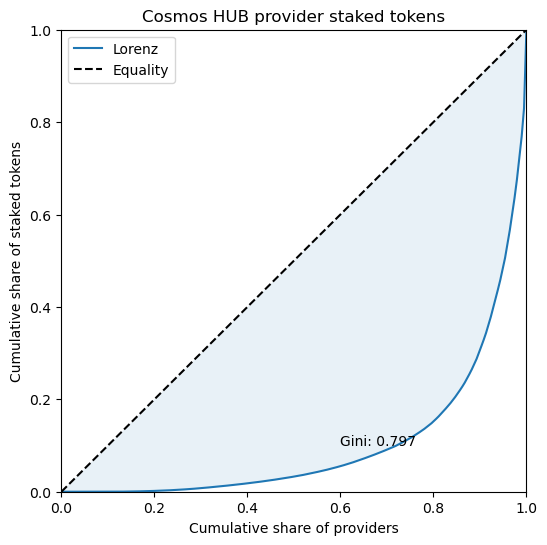

In [14]:
plot_lorenz_curve(resp, title="Cosmos HUB provider staked tokens")

In [15]:
resp_solana = client.get_provider_stake_shares(
    asset_slug="solana",
    limit=200,
    is_active=True,          # set to None to include inactive
    include_reward_rate=True
)
print("Total staked tokens:", resp_solana["total_staked_tokens"])
for p in resp_solana["providers"]:
    print(p["provider"], p["staked_tokens"], p["reward_rate"], p["share"])

Total staked tokens: 413847099.60055584
figment-networks 12568382.867571848 6.14 0.030369628975780712
jupiter 12311454.43662082 6.58 0.029748799613441304
helius 11248002.835087722 6.619999999999999 0.02717912689479826
binance-staking 10681115.879702324 6.61 0.025809328831860146
kiln 9938572.238318413 6.132907022622019 0.024015082497644898
p2p-validator 8726563.926973425 5.982381847532721 0.02108644457191142
ledger-by-figment 8298597.39982949 6.04 0.020052327074031148
galaxy 7846971.949582397 6.24 0.018961041305246007
staking-facilities 6724901.14399446 6.619999999999999 0.016249723993439408
everstake 6470254.660216084 6.04 0.015634408617243318
coinbase 5826052.166918305 6.052375390993837 0.01407778904948614
staked 5468029.099059504 5.94 0.013212679524242727
chorus-one 3892842.078973838 5.99 0.009406474233433553
upbit-staking 3842982.50721856 6.218334294627562 0.009285995989648826
twinstake 3514634.254375027 5.94 0.008492591243885345
kraken 2782369.154733934 5.94 0.006723181477940692
ok

<Axes: title={'center': 'Solana provider staked tokens'}, xlabel='Cumulative share of providers', ylabel='Cumulative share of staked tokens'>

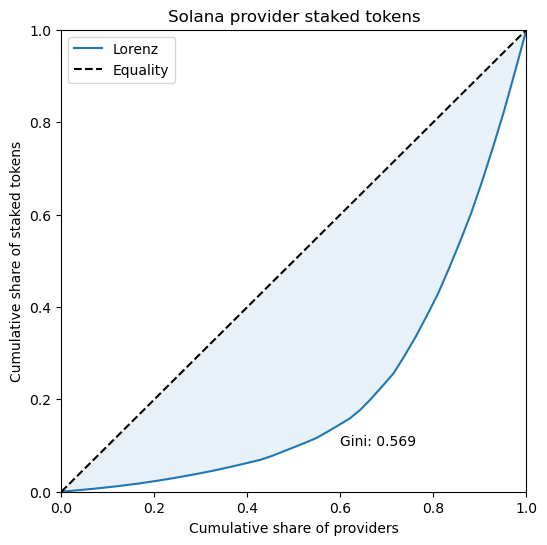

In [16]:
plot_lorenz_curve(resp_solana, title="Solana provider staked tokens")

In [31]:
def create_distribution(asset_slug):
    resp = client.get_provider_stake_shares(asset_slug=asset_slug, limit=200, is_active=True, include_reward_rate=True)
    plot_lorenz_curve(resp, title=f"Provider staked token for {asset_slug}")
    print(f'Untracked share for {asset_slug}: {resp["untracked_share"]}')

In [28]:
def create_distributions(asset_slugs):
    for asset_slug in asset_slugs:
        create_distribution(asset_slug)

Untracked share 0.6553101006606341


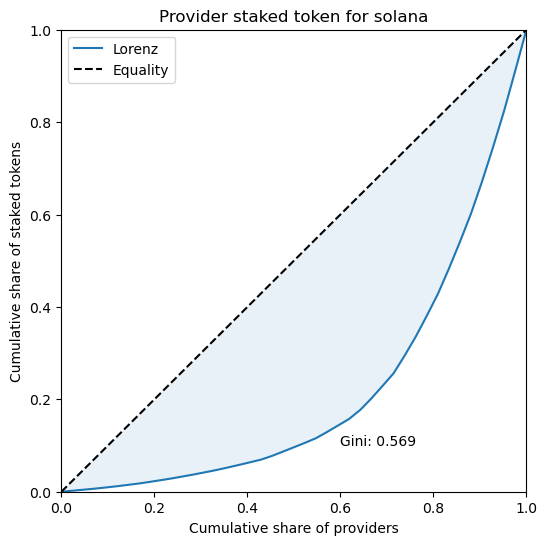

In [20]:
# Solana
create_distribution("solana")

Untracked share 0.04700423693318196


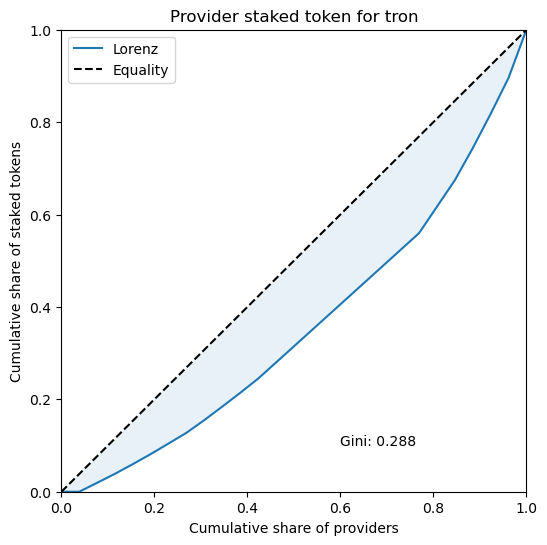

In [21]:
# TRON
create_distribution("tron")

Untracked share for cardano: 0.35673257212116427
Untracked share for waves: 0.308236533469015
Untracked share for cosmos: 0.007852429011950724
Untracked share for avalanche: 0.8823647283394281
Untracked share for hyperliquid: 0.00745005229144981


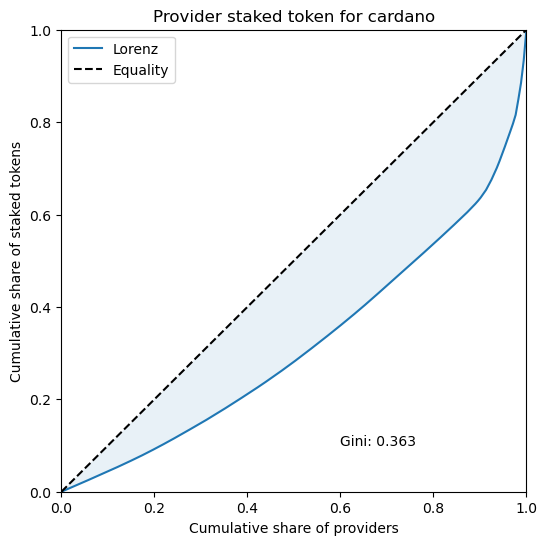

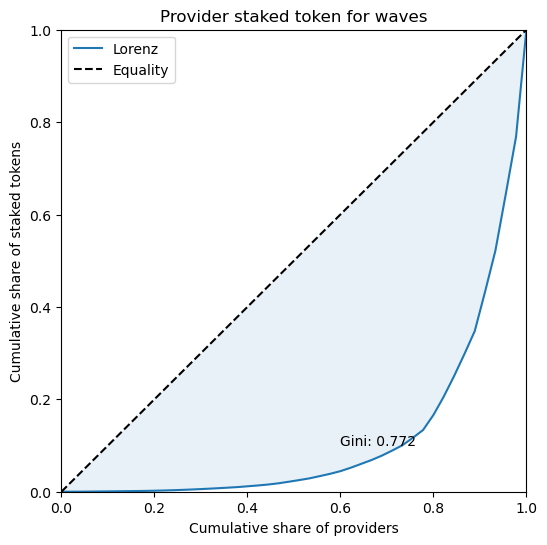

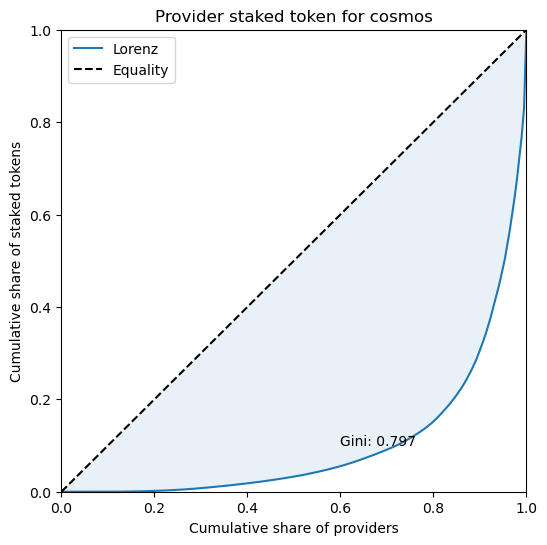

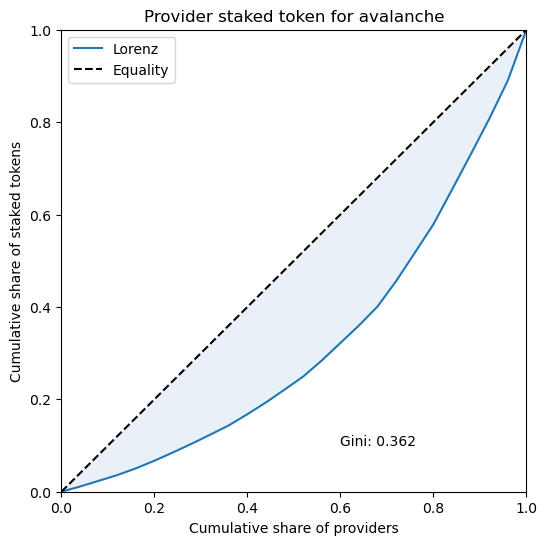

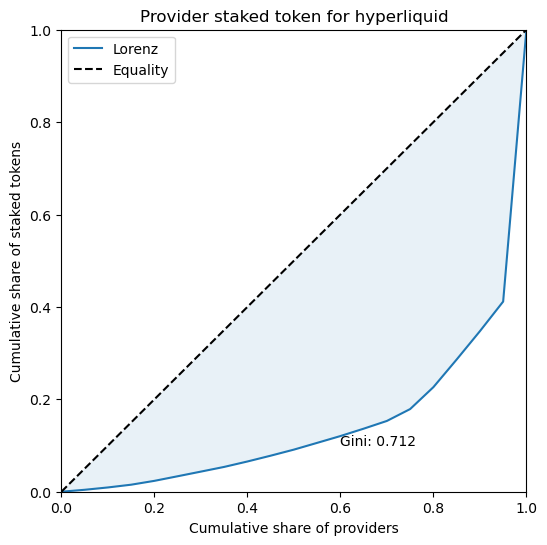

In [38]:
assets = ["cardano", "waves", "cosmos", "avalanche", "hyperliquid"]
create_distributions(assets)